# Big Font **Import libraries**

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
pd.set_option ('display.max_columns', 100)
import warnings
warnings.filterwarnings ('ignore')

import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

In [15]:
# Uploading the Data
log = pd.read_csv ('Well log data path')
# count = (log == -999.25).sum().sum()

means = log.apply(lambda col: col[col!= -999.25].mean(), axis=0)

# Replace -999.25 with the mean for each column
for col in log.columns:
    log[col] = log[col].apply(lambda x: means[col] if x == -999.25 else x)

count = (log == -999.25).sum().sum()
log

# Features Names
# DEPTH.m                    :Well depth
# AZIM .dega                 :Azimuth
# BS   .in                   :Bit Size
# CALS .in                   :Secondary Caliper
# DEVI .dega                 :Deviation
# DRHO .g/cm3                :Density correction value
# DT   .us/ft                :Sonic travel time
# FC13 .in                   :Formation factor at 13 inches
# FC24 .in                   :Formation factor at 24 inches
# FCAL .in                   :Formation factor from caliper
# GR   .gAPI                 :Gamma ray
# HTEN .lbf                  :Head Tension
# ICV  .m3                   :Integrated Cement Volume
# IHV  .m3                   :Integrated Hole Volume
# LLD  .ohm.m                :Deep resistivity
# LLS  .ohm.m                :Shallow resistivity
# MRES .ohm.m                :Mud Resistivity
# MSFL .ohm.m                :Micro-spherically focused log resistivity
# MTEM .degC                 :Mud Temperature
# NPHI .                     :Neutron porosity
# PEF  .                     :Photoelectric factor
# RHOB .g/cm3                :Bulk density
# SP   .MV                   :Spontaneous Potential
# SPED .M/H                  :Cable Speed
# TENS .KG                   :Tension


,DEPTH,CALS,DEVI,DRHO,FC13,FC24,FCAL,TENS,HTEN,MRES,MTEM,NPHI,LLD,LLS,SPED,PEF,MSFL,SP,GR,RHOB,DT
0,1719.9692,12.669097,40.757767,-0.014667,11.935062,12.813524,12.374293,3664.540307,1586.760024,0.048833,68.085656,0.186861,-3.0000,2.222446,634.870293,4.698056,-1.00000,79.255335,29.11370,2.449076,73.397435
1,1720.1216,12.441200,40.581900,-0.014667,12.160400,12.148000,12.154200,3257.998000,1442.777000,0.048833,61.451000,0.339000,-3.0000,2.222446,690.102400,4.698056,-1.00000,43.594700,14.58280,2.449076,59.408000
2,1720.2740,12.441200,40.578900,-0.014667,12.157100,12.161200,12.159100,3260.952000,1448.106000,0.048833,61.481800,0.357100,-3.0000,2.222446,686.423300,4.698056,-1.00000,43.657100,14.78220,2.449076,59.280500
3,1720.4264,12.441200,40.576200,-0.014667,12.160900,12.189000,12.175000,3270.889000,1452.003000,0.048833,61.486600,0.380100,-3.0000,2.222446,688.939900,4.698056,-1.00000,43.906800,15.13210,2.449076,60.467600
4,1720.5788,12.441200,40.570600,-0.014667,12.176400,12.190900,12.183600,3277.603000,1458.933000,0.048833,61.513300,0.396000,-3.0000,2.222446,688.939900,4.698056,-1.00000,44.119000,15.69360,2.449076,55.195400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8736,3051.3224,12.421900,40.659400,-0.002700,12.325700,12.692500,12.509100,3846.670000,1370.807000,0.045200,74.550900,0.211400,0.6058,0.493500,627.920800,4.495200,0.63220,100.000000,18.00920,2.383200,72.579500
8737,3051.4748,12.401600,40.670800,-0.003000,12.339300,12.866900,12.603100,3846.938000,1330.819000,0.045400,73.912900,0.220300,0.6104,0.492700,624.157500,4.325700,0.61430,100.000000,17.69330,2.387400,73.513000
8738,3051.6272,12.392600,40.682000,-0.002100,12.373300,13.029700,12.701500,3852.578000,1352.011000,0.045300,73.922800,0.226500,0.6112,0.488900,628.669000,4.283100,0.60310,100.000000,18.44450,2.383300,73.929200
8739,3051.7796,12.392600,40.684000,-0.003500,12.428700,13.049200,12.739000,3857.681000,1337.743000,0.045100,73.903200,0.228300,0.6060,0.482500,622.011400,4.324900,0.58870,100.000000,18.18140,2.377500,74.954900


In [16]:
## Data Cleaning

# Drop the rows with DT > 10.0000
log = log[log['DT'] <= 100.0000]

# Calculate the mean excluding 300.0000
mean_excluding_300 = log ['SP'][log ['SP']!= 300.0000].mean()
# Replace 300.0000 with the mean
log ['SP'] = log ['SP'].apply(lambda x: mean_excluding_300 if x == 300.0000 else x)


# Calculate the mean excluding 300.0000
mean_excluding_128 = log ['NPHI'][log ['NPHI']!= 12.8738].mean()
# Replace 300.0000 with the mean
log ['NPHI'] = log ['NPHI'].apply(lambda x: mean_excluding_128 if x == 12.8738 else x)

# Calculate the mean excluding 300.0000
mean_excluding_127 = log ['NPHI'][log ['NPHI']!= 12.755400].mean()
# Replace 300.0000 with the mean
log ['NPHI'] = log ['NPHI'].apply(lambda x: mean_excluding_127 if x == 12.755400 else x)


# Calculate the mean excluding 300.0000
mean_excluding_865 = log ['LLD'][log ['LLD']!= -865.7502].mean()
# Replace 300.0000 with the mean
log ['LLD'] = log ['LLD'].apply(lambda x: mean_excluding_865 if x == -865.7502 else x)


# Calculate the mean excluding 300.0000
mean_excluding_000 = log ['GR'][log ['GR']!= 0.0000].mean()
# Replace 300.0000 with the mean
log ['GR'] = log ['GR'].apply(lambda x: mean_excluding_000 if x == 0.0000 else x)

In [17]:
log = log[['DEPTH','CALS','LLD','LLS','GR','RHOB','NPHI','DT']]
log

,DEPTH,CALS,LLD,LLS,GR,RHOB,NPHI,DT
0,1719.9692,12.669097,-3.0000,2.222446,29.11370,2.449076,0.186861,73.397435
1,1720.1216,12.441200,-3.0000,2.222446,14.58280,2.449076,0.339000,59.408000
2,1720.2740,12.441200,-3.0000,2.222446,14.78220,2.449076,0.357100,59.280500
3,1720.4264,12.441200,-3.0000,2.222446,15.13210,2.449076,0.380100,60.467600
4,1720.5788,12.441200,-3.0000,2.222446,15.69360,2.449076,0.396000,55.195400
...,...,...,...,...,...,...,...,...
8736,3051.3224,12.421900,0.6058,0.493500,18.00920,2.383200,0.211400,72.579500
8737,3051.4748,12.401600,0.6104,0.492700,17.69330,2.387400,0.220300,73.513000
8738,3051.6272,12.392600,0.6112,0.488900,18.44450,2.383300,0.226500,73.929200
8739,3051.7796,12.392600,0.6060,0.482500,18.18140,2.377500,0.228300,74.954900


In [18]:
## Feature Importance
 
from scipy.stats import pearsonr

# Assume 'data' is your pandas DataFrame containing the dataset
# Replace 'target_column' with the actual name of your target variable column
target = log['DT']

# Drop the DT column from the features
features = log.drop('DT', axis=1)

scaler = StandardScaler()
featuress = scaler.fit_transform(features)

# Convert data to DMatrix format (required by XGBoost)
dtrain = xgb.DMatrix(features, label=target)


# Initialize the XGBoost regressor
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'random_state': 42
}
model = xgb.train(params, dtrain)

# Get feature importance from the XGBoost model
feature_importances_xgb = model.get_score(importance_type='weight')

# Calculate the sum of all feature importances
importance_sum = sum(feature_importances_xgb.values())

# Convert the feature importance dictionary to a DataFrame and calculate percentages
feature_importance_df_xgb = pd.DataFrame([(feature, importance / importance_sum * 100) for feature, importance in feature_importances_xgb.items()],
                                          columns=['Feature', 'Importance (%)'])
feature_importance_df_xgb = feature_importance_df_xgb.sort_values(by='Importance (%)', ascending=False)

# Calculate the correlation coefficient between each feature and the target variable
correlation_coefficients = {}
for feature in features.columns:
    correlation, _ = pearsonr(features[feature], target)
    correlation_coefficients[feature] = correlation

# Display the feature importance DataFrame
print(feature_importance_df_xgb)

  Feature  Importance (%)
0   DEPTH       23.679727
6    NPHI       17.717206
5    RHOB       15.161840
1    CALS       12.265758
4      GR       11.243612
2     LLD       10.562181
3     LLS        9.369676


In [19]:
## Training and Testing 
# Split the data into training and testing sets

split_value = 7000
log_train = log.iloc[log.index < split_value]
log_test = log.iloc[log.index >= split_value]

X_train2 = log_train.drop('DT', axis=1)
y_train2 = log_train['DT']

X_test2 = log_test.drop('DT', axis=1)
y_test2 = log_test['DT']

# Standardize the features
scaler = StandardScaler()
X_train2_scaled = scaler.fit_transform(X_train2)
X_test2_scaled = scaler.transform(X_test2)

# Create an instance of the GradientBoostingRegressor
XGB = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1,max_depth=3, random_state=42)

# Fit the model to the training data
XGB.fit(X_train2_scaled, y_train2)

# Make predictions on the testing data
y_pred_train = XGB.predict(X_train2_scaled)
y_pred_test = XGB.predict(X_test2_scaled)

# Calculate evaluation metrics for the training set
mae2_train = mean_absolute_error(y_train2, y_pred_train)
rmse2_train = root_mean_squared_error(y_train2, y_pred_train)
r22_train = r2_score(y_train2, y_pred_train)

print(f"Mean Absolute Error (training): {mae2_train}")
print(f"Root Mean Squared Error (training): {rmse2_train}")
print(f"R-squared (training): {r22_train}")

# Calculate evaluation metrics for the testing set
mae2_test = mean_absolute_error(y_test2, y_pred_test)
rmse2_test = root_mean_squared_error(y_test2, y_pred_test)
r22_test = r2_score(y_test2, y_pred_test)

print(f"Mean Absolute Error (testing): {mae2_test}")
print(f"Root Mean Squared Error (testing): {rmse2_test}")
print(f"R-squared (testing): {r22_test}")

Mean Absolute Error (training): 1.8642562128330618
Root Mean Squared Error (training): 2.908406671734608
R-squared (training): 0.8850003422943707
Mean Absolute Error (testing): 3.2710823656742765
Root Mean Squared Error (testing): 4.336754095461597
R-squared (testing): 0.8479788249178242


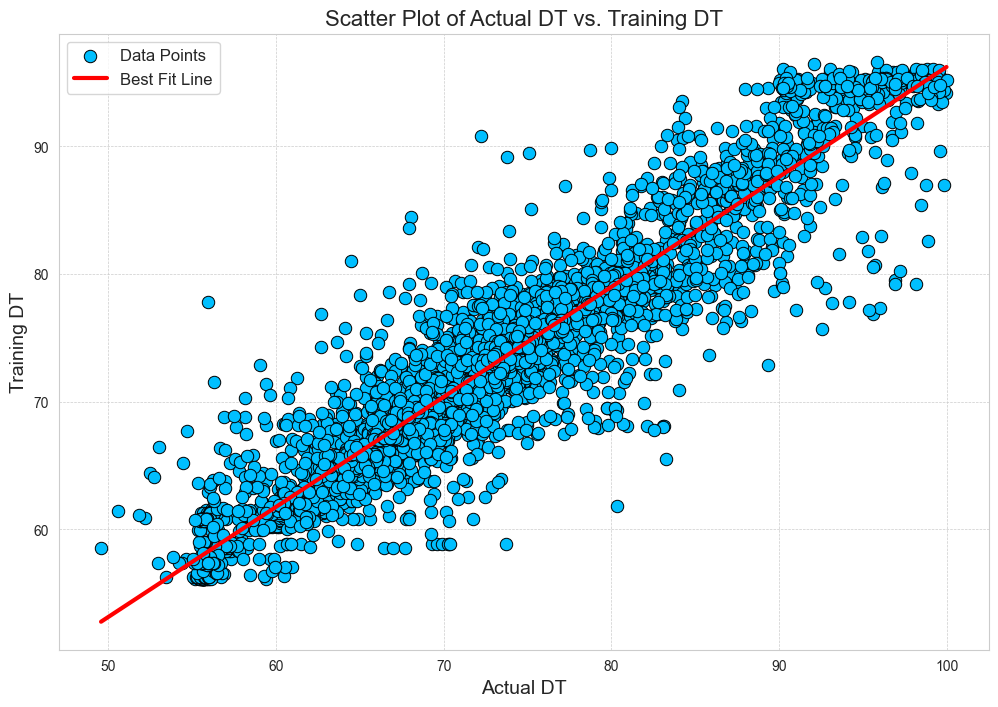

In [20]:
## Visualizing the model performance
# Scatter Plot of Actual DT vs. Training DT

sns.set_style("whitegrid")

# Create the plot
plt.figure(figsize=(12, 8))

# Scatter plot with seaborn styling
sns.scatterplot(x=y_train2, y=y_pred_train, edgecolors='black', color='deepskyblue', s=80, label='Data Points')

# Adding a line of best fit
fit = np.polyfit(y_train2, y_pred_train, 1)
fit_fn = np.poly1d(fit)
sns.lineplot(x=y_train2, y=fit_fn(y_train2), color='red', label='Best Fit Line', linewidth=3)

# Customize the plot
plt.xlabel('Actual DT', fontsize=14)
plt.ylabel('Training DT', fontsize=14)
plt.title('Scatter Plot of Actual DT vs. Training DT', fontsize=16)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(fontsize=12)

# Show the plot
plt.show()

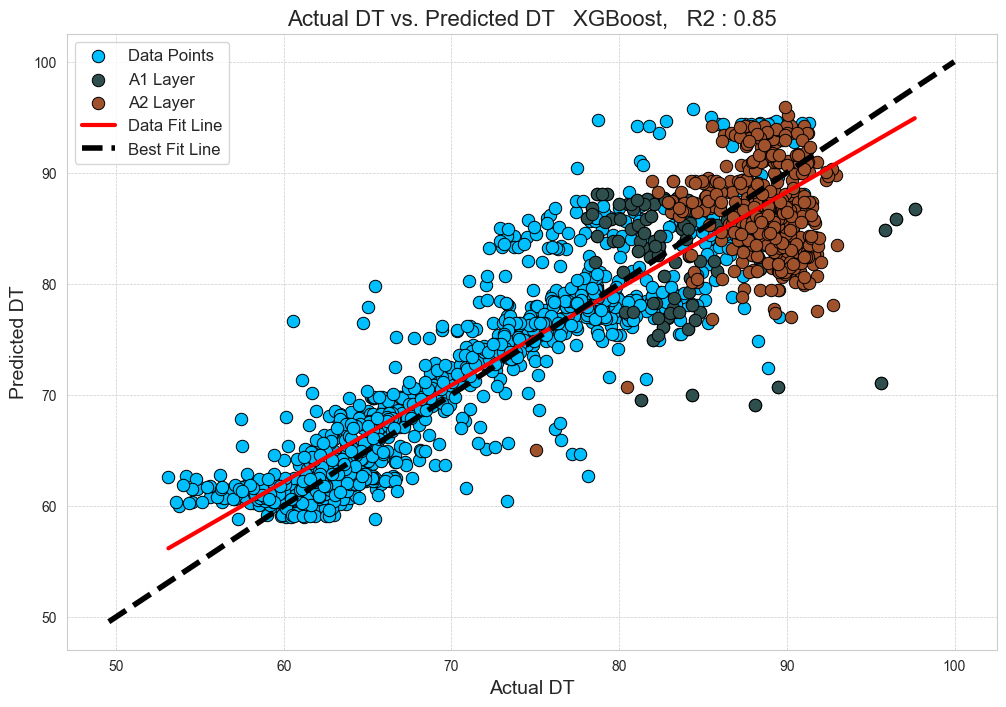

In [21]:
# Scatter Plot of Actual DT vs. Predicted DT
sns.set_style("whitegrid")

# Create the plot
plt.figure(figsize=(12, 8))

# Get indices where depth is between 2930 and 2990
depth_indices = (X_test2['DEPTH'] >= 2930) & (X_test2['DEPTH'] <= 2990)
depth_indices2 = (X_test2['DEPTH'] >= 2877) & (X_test2['DEPTH'] <= 2891)
# depth_indices3 = (X_test2['DEPTH'] >= 2903) & (X_test2['DEPTH'] <= 2922)

# Scatter plot with seaborn styling
sns.scatterplot(x=y_test2[~depth_indices], y=y_pred_test[~depth_indices], edgecolors='black', color='deepskyblue', s=80, label='Data Points')

sns.scatterplot(x=y_test2[depth_indices2], y=y_pred_test[depth_indices2], edgecolors='black', color='darkslategray', s=80, label='A1 Layer')
sns.scatterplot(x=y_test2[depth_indices], y=y_pred_test[depth_indices], edgecolors='black', color='sienna', s=80, label='A2 Layer')
# sns.scatterplot(x=y_test2[depth_indices3], y=y_pred_test[depth_indices3], edgecolors='black', color='green', s=80, label='Data Points (in range)')

# Adding a line of best fit
fit = np.polyfit(y_test2[~depth_indices], y_pred_test[~depth_indices], 1)
fit_fn = np.poly1d(fit)
sns.lineplot(x=y_test2, y=fit_fn(y_test2), color='red', label='Data Fit Line', linewidth=3)
plt.plot([log ['DT'].min(), log ['DT'].max()], [log ['DT'].min(), log ['DT'].max()], 'k', linestyle='--', lw=4, label='Best Fit Line')

rounded_value = round(r22_test, 2)

# Customize the plot
plt.xlabel('Actual DT', fontsize=14)
plt.ylabel('Predicted DT', fontsize=14)
plt.title(f'Actual DT vs. Predicted DT   XGBoost,   R2 : {rounded_value}', fontsize=16)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(fontsize=12)

# plt.savefig('The place where you want to save the scatter plot', dpi=300)
# Show the plot
plt.show()

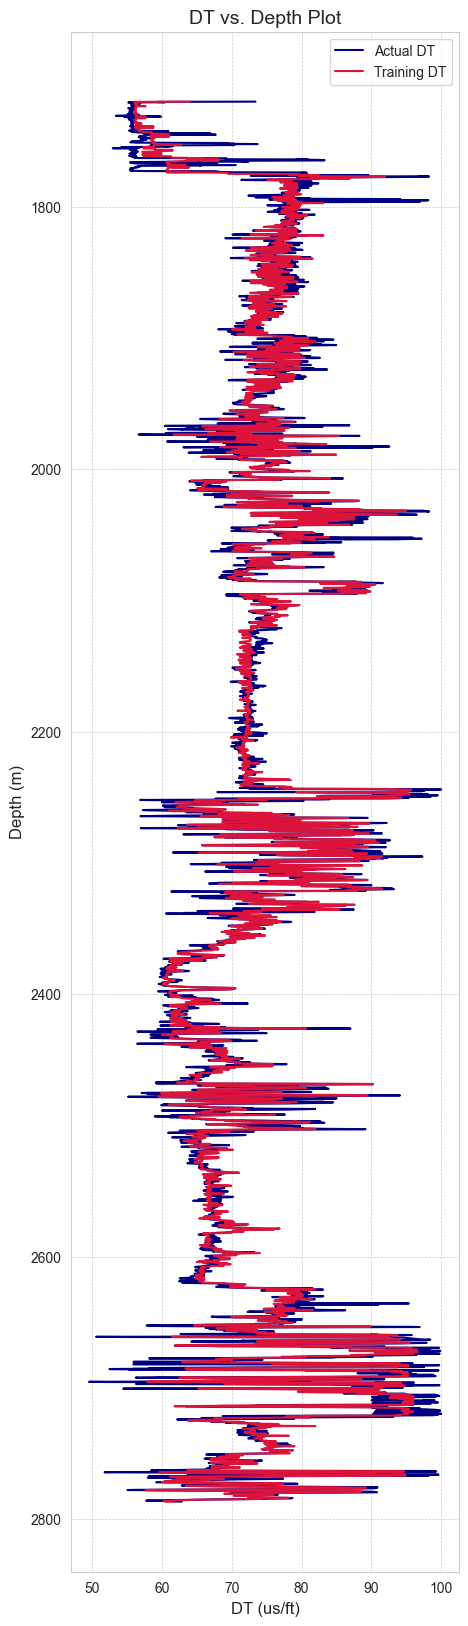

In [22]:
# DT vs. Depth Plot for the Training

# Create the plot
plt.figure(figsize=(5, 20))

# Plot the actual DT values
plt.plot(y_train2, log_train ['DEPTH'], color='navy', label='Actual DT')

# Plot the predicted DT values
plt.plot(y_pred_train, log_train ['DEPTH'], color='crimson', label='Training DT')

# Customize the plot
plt.xlabel('DT (us/ft)', fontsize=12)
plt.ylabel('Depth (m)', fontsize=12)
plt.title('DT vs. Depth Plot', fontsize=14)
plt.gca().invert_yaxis()  # Invert y-axis
plt.grid(True, linestyle='--', linewidth=0.5)  # Adjust grid lines
plt.legend()

# Show the plot
plt.show()

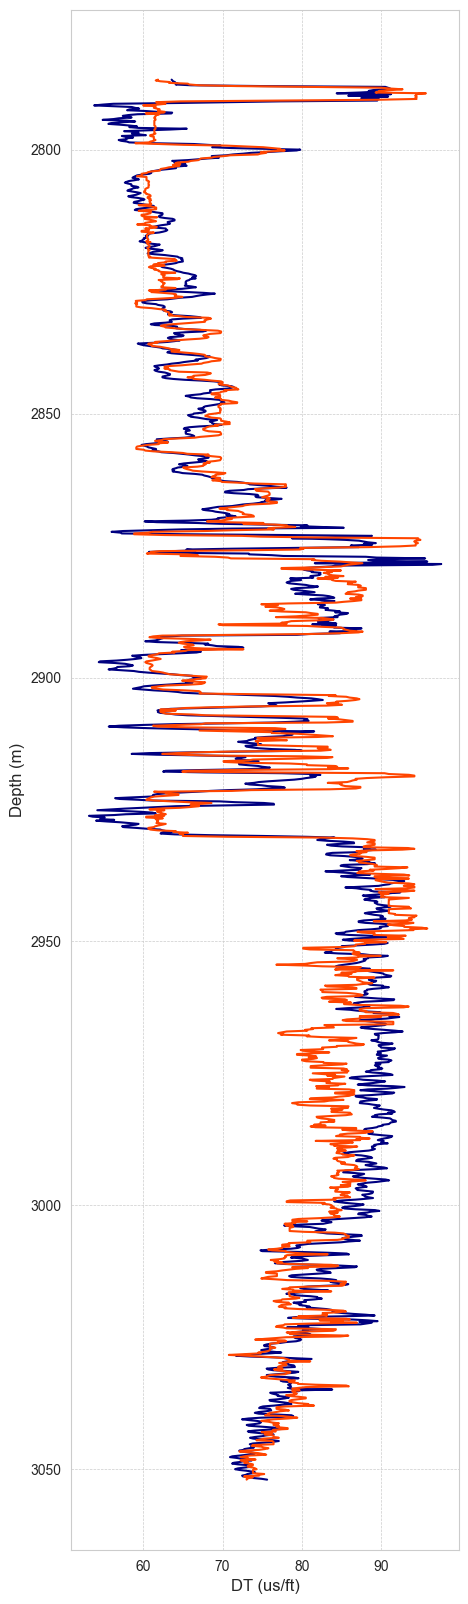

In [23]:
# Create the plot
plt.figure(figsize=(5, 20))

# Plot the actual DT values
plt.plot(y_test2, log_test['DEPTH'], color='navy', label='Actual DT')

# Plot the predicted DT values
plt.plot(y_pred_test, log_test['DEPTH'], color='orangered', linestyle='-', label='Predicted DT')

# Customize the plot
plt.xlabel('DT (us/ft)', fontsize=12)
plt.ylabel('Depth (m)', fontsize=12)
# plt.title(f'DT vs Depth   XGBoost,   R2 : {rounded_value}', fontsize=16)
plt.gca().invert_yaxis()  # Invert y-axis
plt.grid(True, linestyle='--', linewidth=0.5)  # Adjust grid lines

# Select the zone from 2930 to 2970 on the depth axis and color it brown
# depth_zone_mask = (log_test['DEPTH'] >= 2876) & (log_test['DEPTH'] <= 2892)
# plt.fill_betweenx(log_test['DEPTH'][depth_zone_mask], plt.xlim()[0], plt.xlim()[1], color='darkslategray', alpha=0.6, label='A1 Layer')

# depth_zone_mask = (log_test['DEPTH'] >= 2930) & (log_test['DEPTH'] <= 2985)
# plt.fill_betweenx(log_test['DEPTH'][depth_zone_mask], plt.xlim()[0], plt.xlim()[1], color='sienna', alpha=0.6, label='A2 Layer')

# plt.legend()

# plt.savefig('The place where you want to save the scatter plot', dpi=300)

# Show the plot
plt.show()